## Islandization of Terrestrial Protected Areas

by Amy Van Scoyoc, Wenjing Xu, Thomas Mueller, Carl Boettiger, Justin Brashares

### Background

Conservation focuses on reversing the loss of habitat surrounding protected areas (PAs) to preserve ecological processes. While several studies have quantified changes in forest cover to highlight the potential isolation of PAs (16–20), there remain no general assessments of PA 'islandization' across biomes.


In this example, we measure the change in habitat continuity around a protected area boundary over a period of 25 years. We use the same method to compare rates of change between two parks in distinct biomes. 

### Import libraries

First, we initialize Earth Engine and the necessary functions and packages.

In [1]:
import ee
ee.Authenticate()
ee.Initialize(project='dse-staff')
print(ee.String('Hello from the Earth Engine servers!').getInfo())

Hello from the Earth Engine servers!


In [2]:
import pandas as pd
import sys

sys.path.append('../src')
from utils import *
from config import *
from analysis import *

In [3]:
# initialize classes
geo_ops = GeometryOperations()
img_ops = ImageOperations()
stats_ops = StatsOperations()
viz = Visualization()
feature_processor = FeatureProcessor(geo_ops, img_ops, stats_ops)
exp_res = ExportResults()

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for JRC/GSW1_0/GlobalSurfaceWater! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_0_GlobalSurfaceWater

  warnings.warn(warning, category=DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for MODIS/006/MOD09A1! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD09A1

  warnings.warn(warning, category=DeprecationWarning)


### Load protected area

Next, we select a protected area to analyze. We obtained data for protected area geometries using the June 2021 World Database on Protected Areas (58). 

For our analysis we chose terrestrial PAs with a valid geometry (not a point), PAs with status of “designated”, “established”, or “inscribed”, and PAs without a “UNESCO-MAB Biosphere Reserve” designation. We also only selected protected areas larger than 200 km2 to ensure that the PA was wide enough to prevent the buffers from overlapping each other.

In [4]:
serengeti = load_protected_area('916').geometry()

Map = geemap.Map()
Map.add_basemap('HYBRID')
Map.centerObject(serengeti, 9)
Map.addLayer(serengeti, {'color': 'red'}, 'serengeti National Park')
Map

Map(center=[-2.3332666874595325, 34.78445430188864], controls=(WidgetControl(options=['position', 'transparent…

### Geometry operations

Now that we have our two protected areas, we will create a 10-km width buffer across their boundaries. We removed any part of the boundary that has intersected with the maximum extent of water by using the map of the global extent of surface water for 1984 to 2021 (62) `ee.Image("JRC/GSW1_0/GlobalSurfaceWater")`. Finally, we assigned biomes to each PA using the global ecoregion layer (61). When multiple biomes were present we retained the biome label with the largest area.

In [5]:
serengeti_buffer_10km = geo_ops.buffer_polygon(serengeti, 10000)
serengeti_masked_10km = geo_ops.mask_water(serengeti_buffer_10km)

Map2 = geemap.Map()
Map2.add_basemap('HYBRID')
Map2.centerObject(serengeti, 9)
Map2.addLayer(serengeti, {'color': 'red'}, 'Serengeti National Park')
Map2.addLayer(serengeti_masked_10km, {'color': 'orange'}, 'Serengeti National Park')
Map2

Map(center=[-2.3332666874595325, 34.78445430188864], controls=(WidgetControl(options=['position', 'transparent…

### Image operations

We will use `MODIS/Terra Surface Reflectance 8-Day L3 Global 500-m SIN Grid (MOD09A1)` imagery to assess habitat discontinuity. 

The 500 m MODIS imagery has the most consistent data quality and coverage for our 25-year analysis compared to Landsat, which suffered the ETM+ Scan line Corrector failure that introduced data gaps (68). The 500 m MODIS imagery is also more adept than 30 m Landsat imagery at capturing the broad landcover patterns while reducing noise from fine-scale spectral heterogeneity, such as individual trees or grazing paddocks (fig. S2).

Here we take the annual median composite image, since this is the best representation of how a landscape looked throughout the year. 

![satellite resolutions](../images/resolutions.png)

In [6]:
modis_ic = img_ops.modis.filter(img_ops.filter_for_year(serengeti_masked_10km, 2010))
band_names = modis_ic.first().bandNames()
composite = modis_ic.reduce(ee.Reducer.median()).rename(band_names).clip(serengeti_masked_10km)

Map3 = geemap.Map()
Map3.add_basemap('HYBRID')
Map3.centerObject(serengeti_masked_10km, 9)
Map3.addLayer(serengeti_masked_10km, {'color': 'orange'}, 'Serengeti National Park')
Map3.addLayer(composite, {'bands': ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'], 'min': 0, 'max': 3000}, 'Annual Composite - MODIS')
Map3

Map(center=[-2.3079726109183865, 34.739854110316216], controls=(WidgetControl(options=['position', 'transparen…

We then calculated two additional bands from the annual median composie to use to assess habitat continuity.  NDVI which stands for the Normalized Difference Vegetation Index and measures the amount of greeness in vegetation and BSI or the Bare Soil Index which measures the reflectance of bare soil without vegetation. These indicies are particularly important in identifying habitat change. 

$$
\mathrm{NDVI} = \frac{\mathrm{NIR} - \mathrm{RED}}{\mathrm{NIR} + \mathrm{RED}}
$$

$$
\mathrm{BSI} = \frac{(\mathrm{SWIR2} + \mathrm{RED}) - (\mathrm{NIR} + \mathrm{BLUE})}{(\mathrm{SWIR2} + \mathrm{RED}) + (\mathrm{NIR} + \mathrm{BLUE})}
$$

In [7]:
# calculate and add NDVI and BSI indicies to the image composite 
image = img_ops.add_indices_to_image(composite)

Much like finding the outline in this image of a cat, our approach highlights the difference or contrast in landscape pattern for a given band or index. The more different the spectral values are between adjacent pixels in a square 3x3 kernel, the higher the gradient value. 

![Cat gradient image](../images/cat.png)

We calculate the gradient magnitude of our image using the following equation: 

$$
\text{Magnitude} = \sqrt{(\nabla_x I)^2 + (\nabla_y I)^2}
$$

This results in the following image where white pixels indicate a higher gradient value (or more difference between neighboring pixels).

In [8]:
single_band = image.select('NDVI')
buffer_img = img_ops.get_gradient_magnitude(single_band).clip(serengeti_masked_10km)
viz_params = {
            'min': 0,
            'max': 0.0004,
            'palette': ['black', 'gray', 'white']
            }

Map4 = geemap.Map()
Map4.add_basemap('HYBRID')
Map4.centerObject(serengeti_masked_10km, 9)
Map4.addLayer(serengeti_masked_10km, {'color': 'orange'}, 'serengeti National Park')
Map4.addLayer(buffer_img, viz_params, '10 km -Gradient Magnitude')
Map4

Map(center=[-2.3079726109183865, 34.739854110316216], controls=(WidgetControl(options=['position', 'transparen…

Of course, we want to be able to compare the gradient magnitude of the buffer to the boundary, to understand how the gradient changes across the boundary. We can do this by creating a smaller 1-km buffer around the boundary and then calculating the gradient magnitude of the boundary. 

In [9]:
boundary_buffer_1km = geo_ops.buffer_polygon(serengeti, 1000)
boundary_img = buffer_img.clip(boundary_buffer_1km)

Map5 = geemap.Map()
Map5.add_basemap('HYBRID')
Map5.centerObject(serengeti_buffer_10km, 9)
Map5.addLayer(boundary_img, {'min': 0, 'max': 0.0004, 'palette': ['black', 'red']}, '1 km - Gradient Magnitude')
Map5

Map(center=[-2.306780438483596, 34.73334733655345], controls=(WidgetControl(options=['position', 'transparent_…

### Edge Index

Once we have the magnitude gradient image for the 1km and 10km boundaries, we are ready to calculate the `edge index`.  We calculate `edge index` as the proportion of the mean magnitude of the boundary to the buffer: 

$$
\text{Edge Index} = \frac{\overline{X}_{\text{boundary}}}{\overline{X}_{\text{buffer}}}
$$

In the year 2010, Serengeti National Park had an edge index of:

In [10]:
# Calculate mean gradient for boundary and buffer
boundary_stats = boundary_img.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=boundary_img.geometry(),
    scale=500,
    maxPixels=1e10
).getInfo()

buffer_stats = buffer_img.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=buffer_img.geometry(),
    scale=500,
    maxPixels=1e10
).getInfo()

boundary_mean = boundary_stats.get('x')
buffer_mean = buffer_stats.get('x')

edge_index = boundary_mean / buffer_mean

print(f'Boundary Mean: {boundary_mean}')
print(f'Buffer Mean: {buffer_mean}')
print(f'Edge Index: {edge_index}')

Boundary Mean: 4.090615029228295e-05
Buffer Mean: 3.7501746486538665e-05
Edge Index: 1.0907798735977883


In [11]:
#feature_info = feature_processor.collect_feature_info(pa, aoi_with_biome)
#features = feature_processor.process_all_bands_ee(image, pa_geometry, aoi, feature_info, year)

### Change overtime

Whether a protected area has an edge at its boundary is not indicative of changes to habitat continuity. Many protected areas have pre-existing natural boundaries, such as mountain ranges or canyons along their borders. 

However, by using satellite imagery to track the spectral difference of PA boundaries relative to surrounding land over time, we can distinguish process of islandization from pre-existing natural boundaries at protected areas edges (e.g., mountain ranges, altitudinal zones). So next, we compare changes in edge index over a 25 year period.  

In [12]:
# run full analysis for Serengeti and Yellowstone National Parks for 23 years
#run_all(wdpaids = ["916", "2013"], start_year=2001, n_years=23, max_workers=10)

In [13]:
#df = exp_res.combine_gcs_csvs(bucket_name='dse-staff',folder_path='protected_areas/tables')
#df.to_csv('/workspace/output/serengeti_yellowstone.csv', index=False)
df = pd.read_csv('/workspace/output/serengeti_yellowstone.csv')

# calculate edge
df['edge_index'] = df['boundary_x_mean'] / df['buffer_x_mean']

# reformat columns for plot
df['WDPA_PID'] = df['WDPA_PID'].astype(str)
df['year'] = df['year'].astype(str)

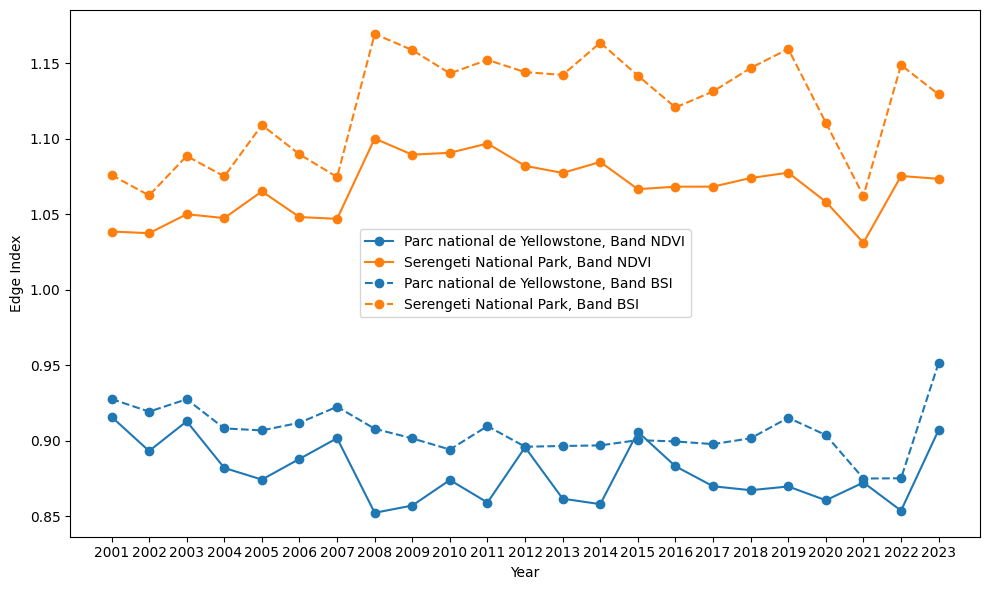

In [14]:
viz.plot_edge_index(df)

Let's take this one step further and visualize the changes in the gradient of BSI overtime. 

In [15]:
# run full image analysis for Serengeti and Yellowstone National Parks for 23 years
#analysis_to_image(wdpaids = ["916", "2013"], start_year=2002, n_years=22, band_name = 'NDVI', max_workers=10)

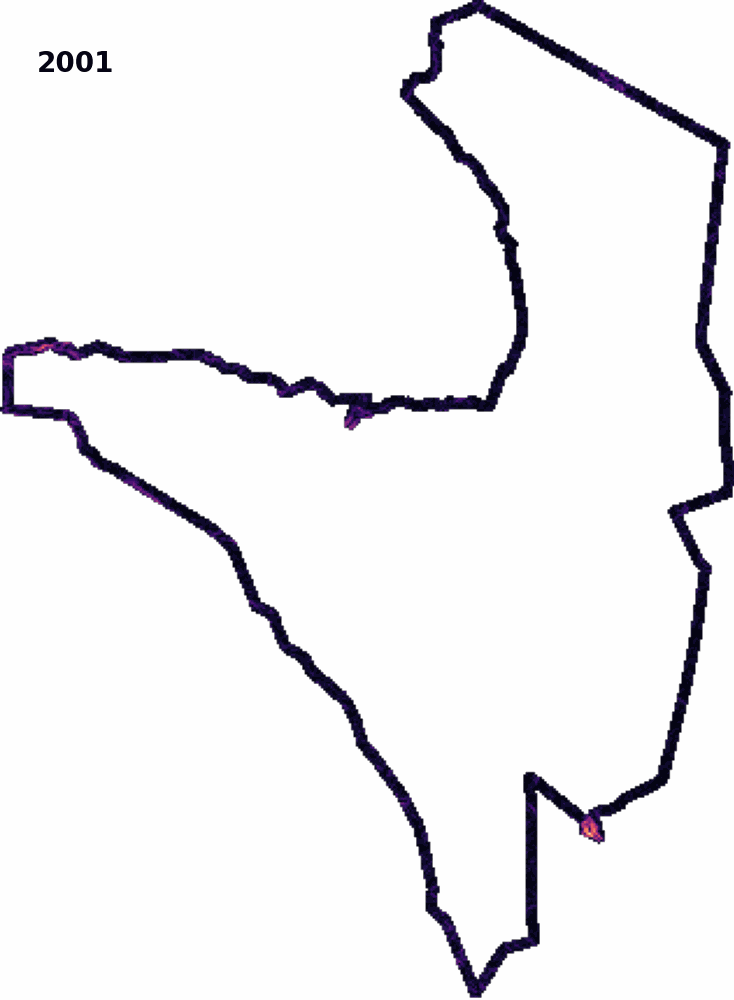

In [16]:
folder = "/workspace/output/cogs/serengeti"
viz.create_gif_from_tifs(folder)

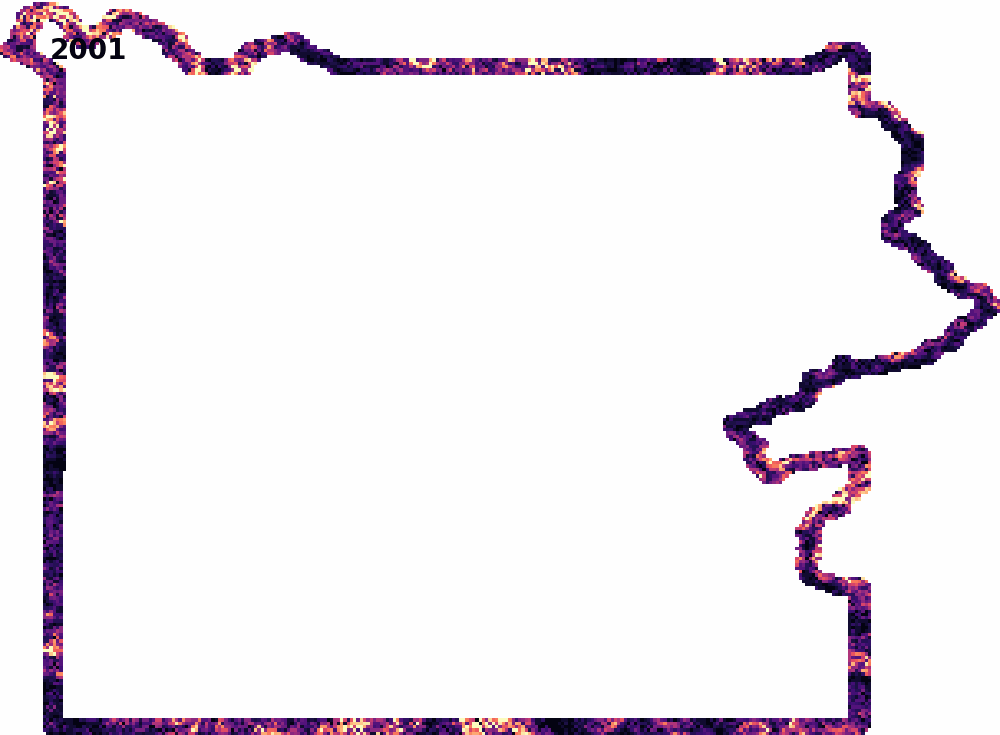

In [17]:
folder2 = "/workspace/output/cogs/yellowstone"
viz.create_gif_from_tifs(folder2)